# AJ_0065.3 - Seurat v3 clustering pipeline

The objective here is to process the data with Seurat v3 pipeline as the alternative to scater + SC3  
The goals are the combination of AJ_0065.1 and AJ_0065.2, namely: 
  
0) Clean, filter and normalize the data  
1) define how cells cluster using k-means clustering  
2) Project the clusters on t-SNE generated in AJ0065.1  
3) Define marker genes and differentially expressed genes for each cluster  
4) Define how many cells from each timepoint fall into each cluster  
  
  Some annotations here will be copied from Seurat v3 package manual

## Run with conda env: R_scRNA_seq_XCR2

In [2]:
library(dplyr)
library(Seurat)
library(readr)
library(tibble)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vsc-hard-mounts/leuven-data/320/vsc32023/miniconda/envs/R_scRNA_seq_XCR2/lib/R/lib/libRblas.so

locale:
[1] C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scater_1.14.0               ggplot2_3.1.1              
 [3] SingleCellExperiment_1.8.0  SummarizedExperiment_1.16.0
 [5] DelayedArray_0.12.0         BiocParallel_1.20.0        
 [7] matrixStats_0.56.0          Biobase_2.46.0             
 [9] GenomicRanges_1.38.0        GenomeInfoDb_1.22.0        
[11] IRanges_2.20.0              S4Vectors_0.24.0           
[13] BiocGenerics_0.32.0         tibble_2.1.1               
[15] readr_1.3.1                 Seurat_3.0.2               
[17] dplyr_0.8.0.1              

loaded via a namespace (and not attached):
  [1] ggbeeswarm_0.6.0 

In [4]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2")

#### Import clean counts and annotation file (prepared in AJ_0065.1)

In [5]:
counts_clean <- read_csv("input/AJ_0065_counts_clean.csv")
counts_clean <- data.frame(counts_clean[,-1], row.names = counts_clean$X1)
head(counts_clean)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)
See spec(...) for full column specifications.


,Day_9_Xi_Mus_33,Day_10_Xi_Mus_25,Day_10_Xi_Mus_32,Day_9_Xi_Mus_27,Day_9_Xi_Mus_36,Day_10_Xi_Mus_30,Day_10_Xi_Mus_33,Day_9_Xi_Mus_32,Day_10_Xi_Mus_34,Day_10_Xi_Mus_28,...,Day_12_Xi_Cast_42,Day_12_Xi_Cast_45,Day_12_Xi_Cast_46,Day_12_Xi_Cast_40,Day_12_Xi_Cast_39,Day_12_Xi_Cast_38,Day_12_Xi_Cast_41,Day_12_Xi_Cast_43,Day_12_Xi_Cast_48,Day_12_Xi_Cast_47
4933401J01Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm18956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
annotation <- read_csv("input/AJ_0065_annotation.csv")
annotation <- data.frame(annotation[,-1], row.names = annotation$X1)
head(annotation)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_character(),
  Timepoint = col_character(),
  Xi = col_character(),
  Cell = col_double(),
  GC_index1_index2 = col_character(),
  Name = col_character()
)


,Timepoint,Xi,Cell,GC_index1_index2,Name
Day_9_Xi_Mus_33,Day_9,Mus,33,GC071392_ACTCTAGG-AAGAGGCA,Day_9_Xi_Mus_33
Day_10_Xi_Mus_25,Day_10,Mus,25,GC071392_ACTCTAGG-ACTCGCTA,Day_10_Xi_Mus_25
Day_10_Xi_Mus_32,Day_10,Mus,32,GC071392_ACTCTAGG-ACTGAGCG,Day_10_Xi_Mus_32
Day_9_Xi_Mus_27,Day_9,Mus,27,GC071392_ACTCTAGG-AGGCAGAA,Day_9_Xi_Mus_27
Day_9_Xi_Mus_36,Day_9,Mus,36,GC071392_ACTCTAGG-ATCTCAGG,Day_9_Xi_Mus_36
Day_10_Xi_Mus_30,Day_10,Mus,30,GC071392_ACTCTAGG-ATGCGCAG,Day_10_Xi_Mus_30


In [7]:
seurat <- CreateSeuratObject(counts = counts_clean, meta.data = annotation, min.cells = 3, min.features = 200, project = "XCR")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

#### Calculate mitochondrial QC metrics

In [8]:
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat, pattern = "^mt-")

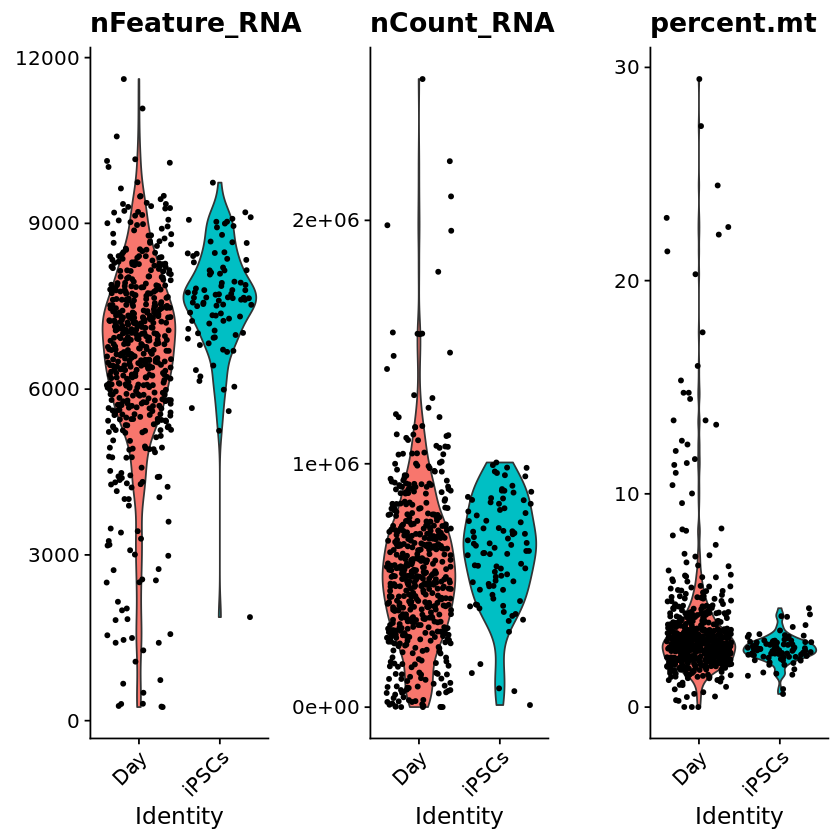

In [9]:
VlnPlot(seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [106]:
# Average number of genes detected
summary(seurat@meta.data$nFeature_RNA)
# Average number of reads per cell
summary(seurat@meta.data$nCount_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    246    5948    6971    6713    7777   11612 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    331  375976  564463  581117  745987 2580532 

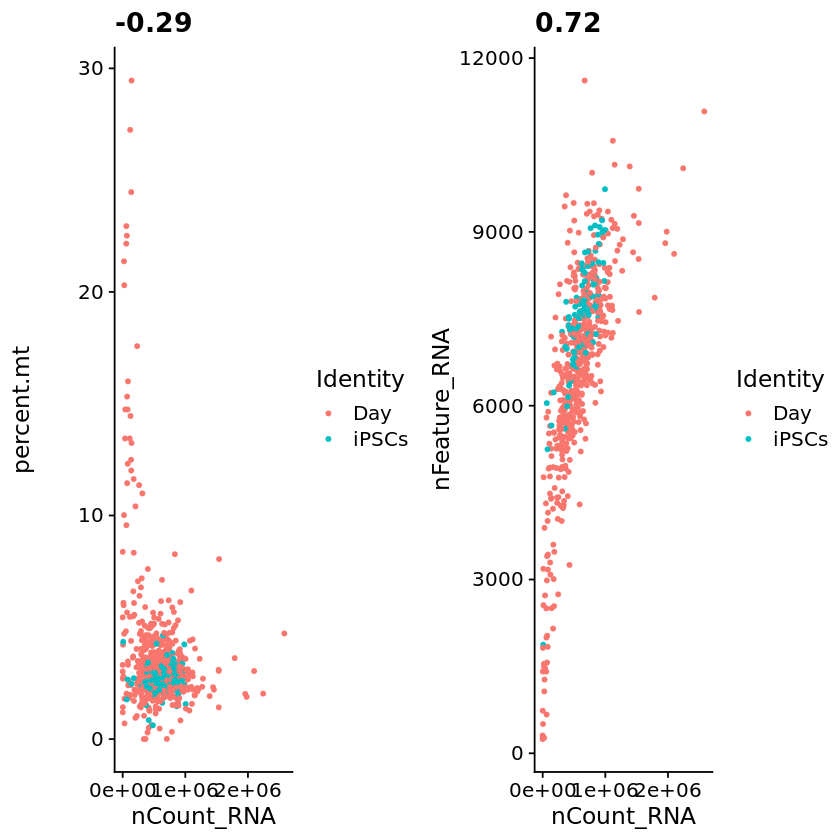

In [11]:
plot1 <- FeatureScatter(seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

In [12]:
seurat <- subset(seurat, subset = nFeature_RNA > 4000 & nFeature_RNA < 10000 & percent.mt < 8)

#### Normalization

In [13]:
seurat <- NormalizeData(seurat, normalization.method = "LogNormalize", scale.factor = 10000)

#### Identification of highly variable features (feature selection)

When using repel, set xnudge and ynudge to 0 for optimal results
Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"

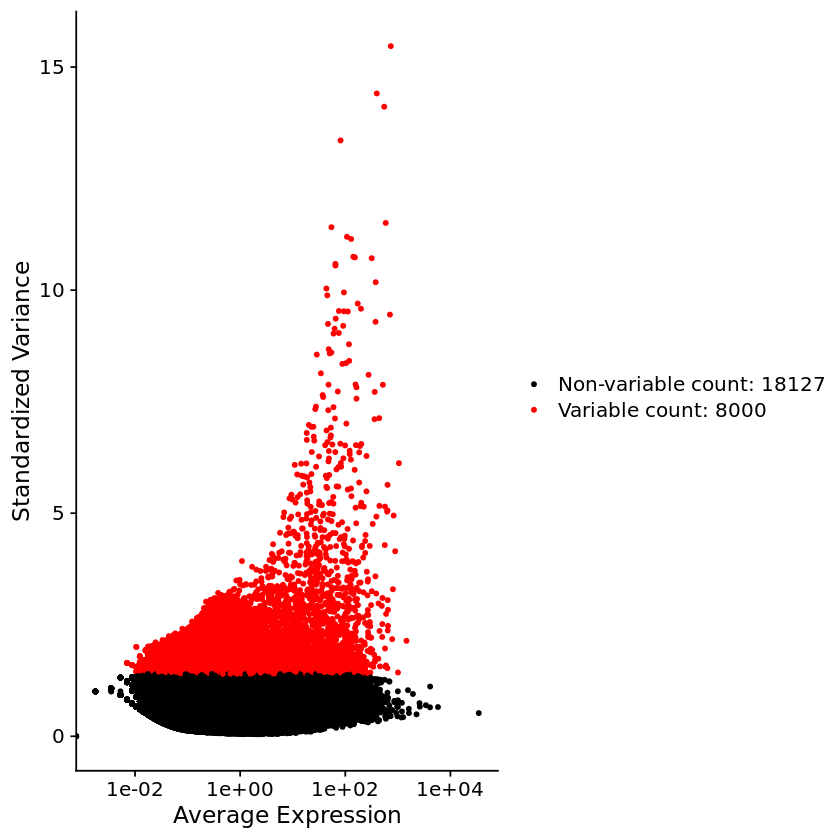

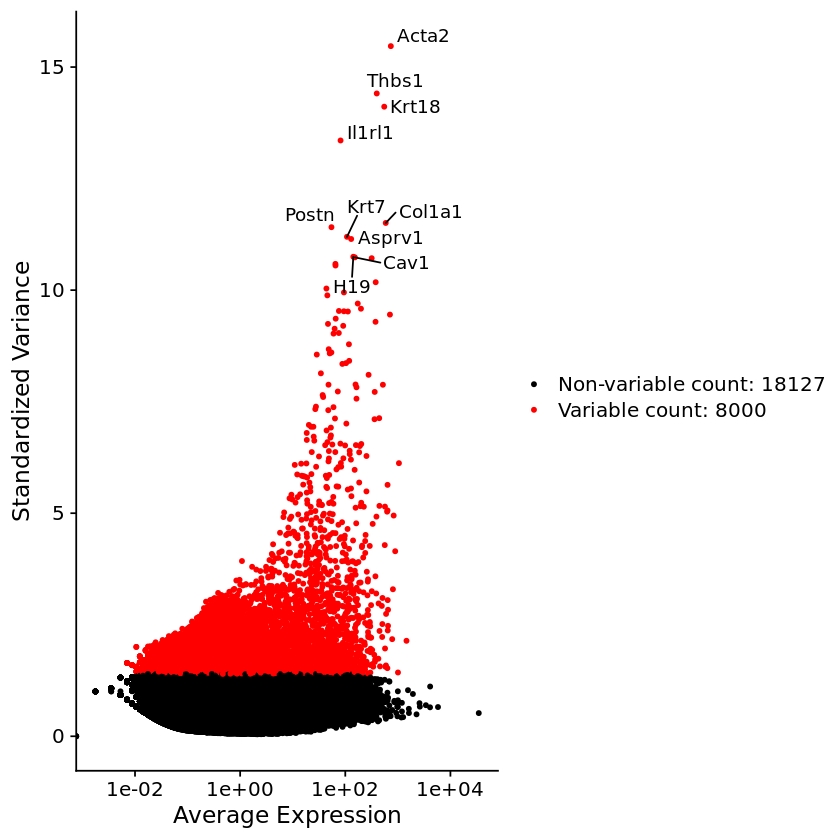

In [14]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 8000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

#### Scaling the data

In [15]:
all.genes <- rownames(seurat)
seurat <- ScaleData(seurat, features = all.genes)

Centering and scaling data matrix


#### Export normalized and scaled data

In [24]:
scaled_counts <- seurat[["RNA"]]@scale.data
write.csv(scaled_counts,"seurat/seurat_scaled.csv")

log_norm_counts <- seurat[["RNA"]]@data
write.csv(log_norm_counts,"seurat/seurat_log_norm.csv")

# These scaled counts are going to be used for generating GRN visualization to color the nodes.

#### Perform linear dimensional reduction

In [16]:
seurat <- RunPCA(seurat, features = VariableFeatures(object = seurat))

PC_ 1 
Positive:  Col1a1, Bgn, Col1a2, Col5a2, Vim, Loxl1, Lox, Lgals1, Efemp2, Thbs1 
	   Timp2, Wls, Col5a1, Fbln5, Mmp14, Ddr2, Ccdc80, Col3a1, Gpx8, Cpe 
	   Serpinh1, Acta2, Aebp1, Oaf, Cav1, Tmem176b, Fbn1, Serpinf1, Col6a1, Cdh11 
Negative:  Bex1, Msh2, Rps4l, Rif1, Hat1, Cdc20, Alg13, Mkrn1, Tdh, Ube2c 
	   Ccnb1, Utf1, Tigar, Cdca8, Usp28, Alpl, Rpa2, Mybl2, Zscan10, Mcm3 
	   Cenpa, Mcm5, Kif22, Chchd10, Hells, Nanog, Aurka, Slc7a3, Phc1, Pttg1 
PC_ 2 
Positive:  Perp, Krt8, S100a16, Krt17, Prr13, Dkkl1, Myo1e, Ly6g6c, S100a14, Tgm2 
	   Lrrfip1, Krtdap, Mal, Tacstd2, Aldh3a1, Jup, Alox12b, Klk10, Lad1, Ethe1 
	   Klk8, Cd109, Dsp, Mboat1, Micu1, St14, Tmem43, Dsc2, Klk11, Sdcbp2 
Negative:  Ifitm3, Rbpms2, Apoe, Tdgf1, Dnmt3l, pCX-eGFP, Cbx1, Dppa5a, Ooep, Dppa4 
	   Slc25a5, Fmr1nb, Pigp, Platr17, Platr14, Fkbp4, Lrrc2, Hsf2bp, Mycn, Tcea3 
	   Gsta4, Nid2, Ifitm1, Nodal, Gdf3, Fth1, Blvrb, Cnn3, Pla2g1b, Upp1 
PC_ 3 
Positive:  Cep164, Dnah17, Isyna1, Entpd1, Stmn2, Fah, C

#### Cluster the cells

In [17]:
seurat <- FindNeighbors(seurat, dims = 1:15)
seurat <- FindClusters(seurat, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 567
Number of edges: 15367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8426
Number of communities: 6
Elapsed time: 0 seconds


#### Dimensionality reduction

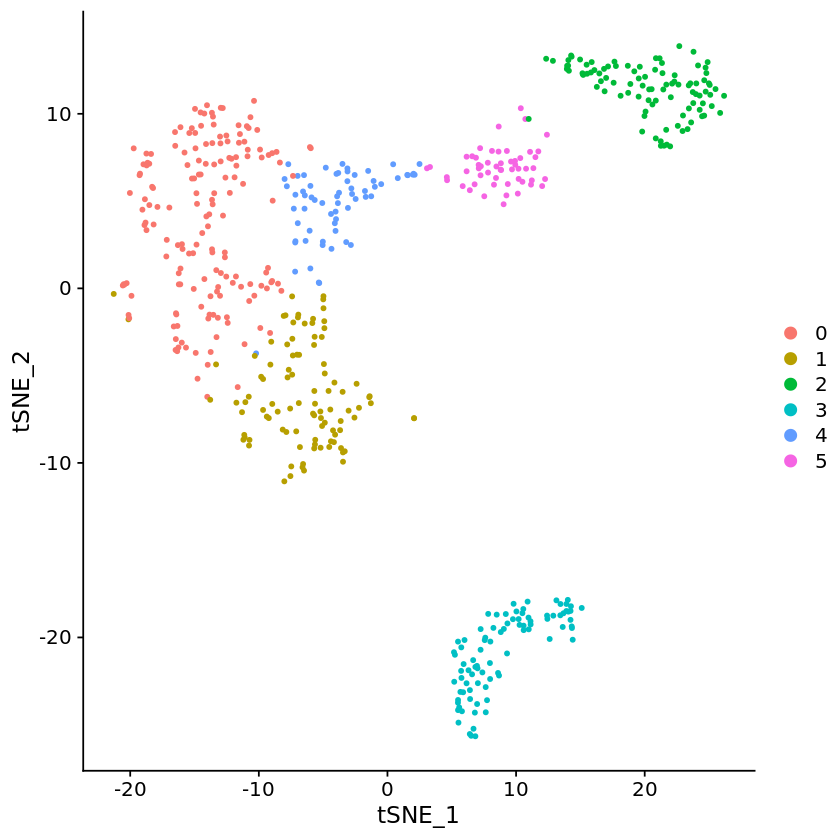

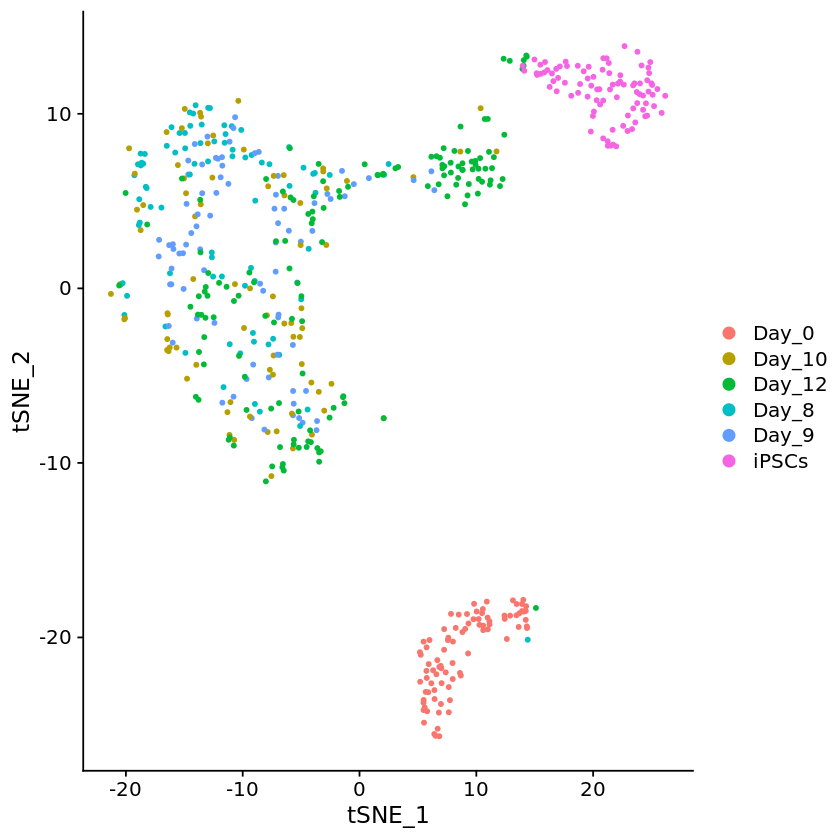

In [20]:
# Lost the seed.use I used for the tSNE in the paper.
# 1234567890 - is the closest I can get to that shape. It's almost identical tho
# But for downstream analyses I am using original seurat object with the same tSNE coordinates as in the paper.
#seurat <- RunTSNE(seurat, dims = 1:15, seed.use = 1234567890)


seurat <- RunTSNE(seurat, dims = 1:15,, seed.use = 1234) 

DimPlot(seurat, reduction = "tsne")
DimPlot(seurat, reduction = "tsne", group.by = "Timepoint")

In [21]:
# Rename a cluster 
## In my case I just want to change them to the logical order 0  = MEFs, 5 = iPSCs
seurat <- RenameIdents(object = seurat,  '0' = '2', '1' = '1','2' = '5', '3' = '0', '4' = '3', '5' = '4')
# Accordingly, change the levels
levels(seurat) <- c('0','1','2','3','4','5')

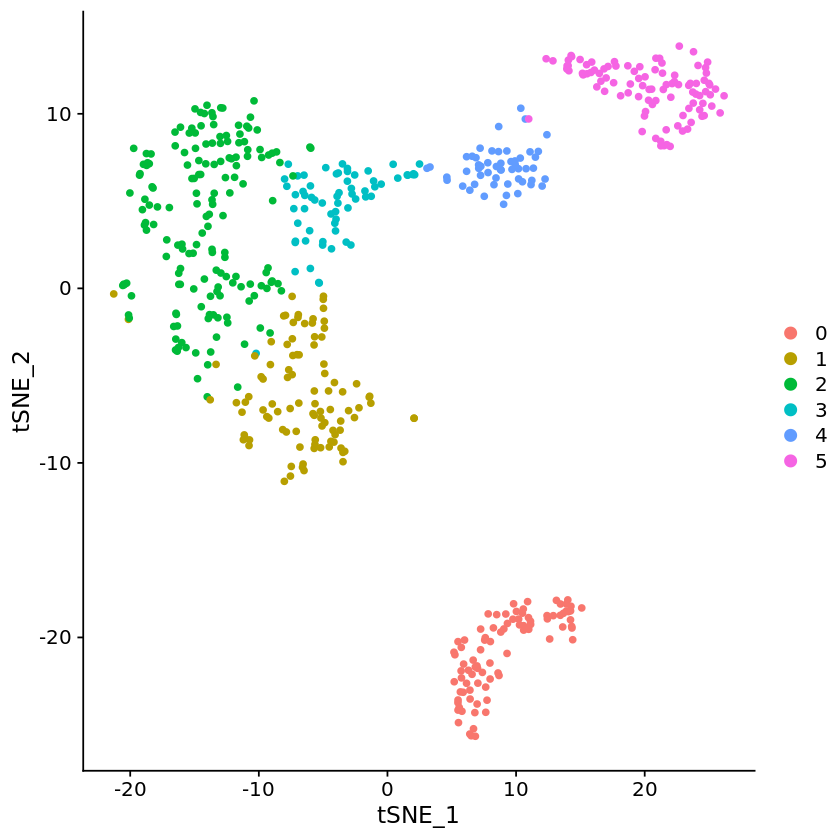

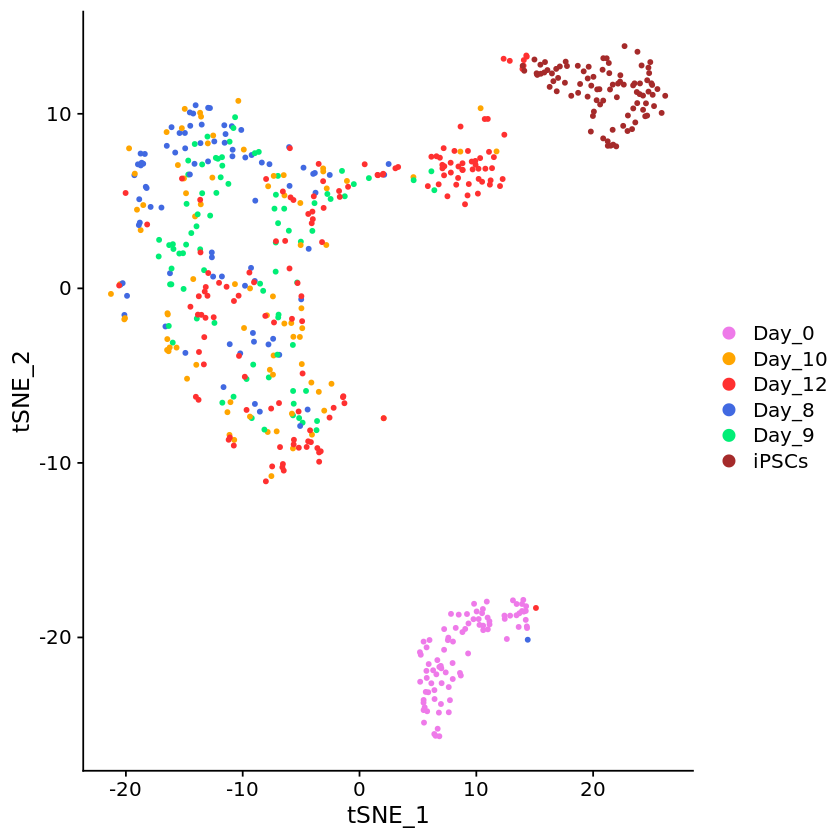

In [22]:
DimPlot(seurat, reduction = "tsne", pt.size = 1.5, alpha =.7)
DimPlot(seurat, reduction = "tsne", group.by = "Timepoint")  +
scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown"))

In [25]:
# Add a column in metadata with new clusters

seurat@meta.data <- seurat@meta.data %>% 
                        rownames_to_column("cell_id") %>%
                        mutate(seurat_clusters_rename = case_when(seurat_clusters == 0 ~ '2',
                                                                  seurat_clusters == 1 ~ '1',
                                                                  seurat_clusters == 2 ~ '5',
                                                                  seurat_clusters == 3 ~ '0',
                                                                  seurat_clusters == 4 ~ '3',
                                                                  seurat_clusters == 5 ~ '4')) %>%
                        column_to_rownames("cell_id")

In [26]:
# Export Seurat object with clustering

saveRDS(seurat, file = "seurat/seurat_clustering.rds")

#### Define the number of cells from each timepoint per cluster

In [87]:
timepoints_pc <- seurat@meta.data %>% 
                        select(Timepoint, seurat_clusters) %>% 
                        group_by(seurat_clusters, Timepoint) %>% 
                        tally() %>%
                        ungroup() %>%
                        dplyr::mutate(new_cluster_names = c(2,2,2,2,1,1,1,1,5,5,0,0,0,3,3,3,3,4,4,4))

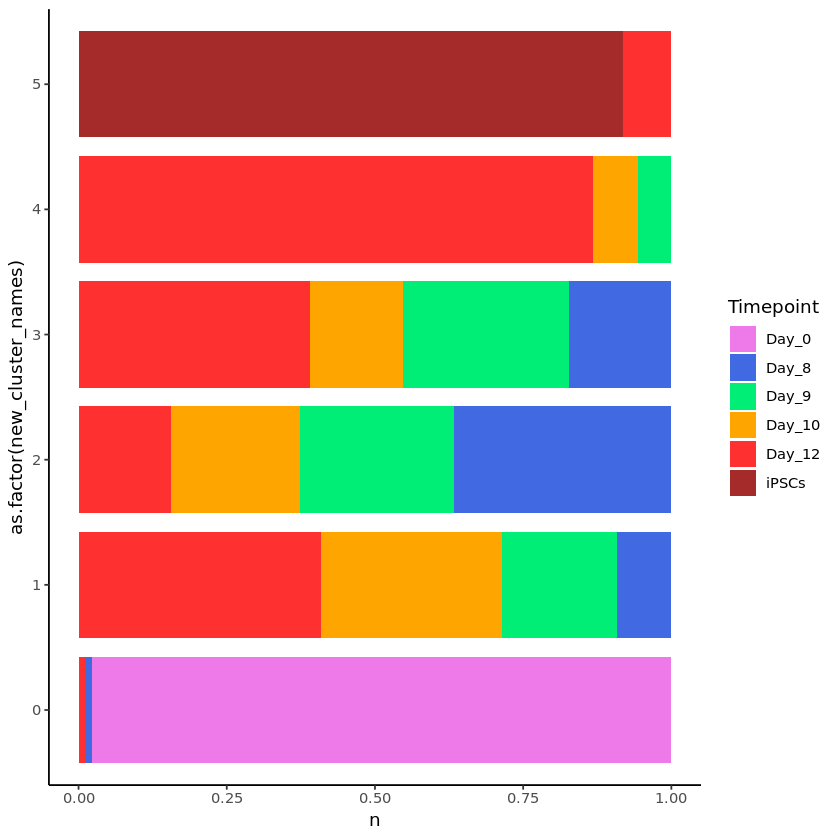

In [60]:
timepoints_per_cluster <- ggplot(timepoints_pc, aes(x = as.factor(new_cluster_names), y = n, fill = factor(Timepoint, levels = c("Day_0","Day_8","Day_9","Day_10","Day_12","iPSCs")))) +
geom_bar(position = "fill", stat = "identity", width = .85)+
scale_fill_manual("Timepoint",values = c("orchid2","royalblue","springgreen2","orange","firebrick1","brown"))+
coord_flip() +
theme_classic()

timepoints_per_cluster

#pdf("AJ_0065.3_timepoints_per_cluster.pdf", useDingbats = FALSE, height = 2, width = 3.3)
#plot(timepoints_per_cluster)
#dev.off()